# Step 2 - Accepted / Reject Loans Classification

## Goals in this Notebook

- Create a combined accepted / rejected loans dataset.
- Do EDA for the combined dataset.
- Create a classification model to predict whether a loan would be accepted. I would expect that there should be a clear cut-off where the loan gets rejected, so a macro f1 score of at least 0.9 should be expected.

## Initialisation

### Dependancies and Data 

In [2]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import constants
import shap
import optuna
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

sns.set_palette("colorblind", 10)

acc_train_path = os.path.join("data", "acc_train.parquet")
df_acc = pl.read_parquet(acc_train_path)
rej_train_path = os.path.join("data", "rej_train.parquet")
df_rej = pl.read_parquet(rej_train_path)

### General Observations

In [2]:
df_rej.glimpse(max_items_per_column=4)

Rows: 24535570
Columns: 9
$ Amount Requested     <f64> 1000.0, 1000.0, 15000.0, 1500.0
$ Application Date     <str> '2007-05-26', '2007-05-26', '2007-05-27', '2007-05-27'
$ Loan Title           <str> 'Wedding Covered but No Honeymoon', 'Consolidating Debt', 'Trinfiniti', 'mdrigo'
$ Risk_Score           <f64> 693.0, 703.0, 645.0, 509.0
$ Debt-To-Income Ratio <str> '10%', '10%', '0%', '9.43%'
$ Zip Code             <str> '481xx', '010xx', '105xx', '209xx'
$ State                <str> 'NM', 'MA', 'NY', 'MD'
$ Employment Length    <str> '4 years', '< 1 year', '3 years', '< 1 year'
$ Policy Code          <f64> 0.0, 0.0, 0.0, 0.0



Rejected and accepted loans have vastly different datasets. Rejected loans have only 9 features, while accepted - 151. Also, the column names are different, features have different format. To review the accepted loans features, navigate to ./data/acc_features.xlsx

In [3]:
df_rej.null_count()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1219,15921114,0,272,21,833994,874


Since we have more than 20M observations, these nulls don't matter too much. However, Risk score null proportion is concerning.

## EDA

### Joining the Datasets

#### Risk Score

TODO check the range of risk score

We'll sample 1M of each dataset to continue with EDA.

In [10]:
df_rej_sample = df_rej.sample(1_000_000, seed=42)
df_acc_sample = df_acc.sample(1_000_000, seed=42)

Our goal is to first find out how to create a dataset for the accepted / rejected loans classification, since right now we have two different datasets with different schema.

I was successful in finding an equivalent column in accepted loans dataset for each of the columns in the rejected loans dataset. The only problematic one is "Risk Score". This one seems to be some kind of a transformation from the original data.

In [ ]:
df_rej.select("Risk_Score").filter(pl.col("Risk_Score") > 0).describe()

describe,Risk_Score
str,f64
"""count""",8.533232e6
"""null_count""",0.0
"""mean""",634.269022
"""std""",65.970081
"""min""",300.0
"""25%""",593.0
"""50%""",638.0
"""75%""",675.0
"""max""",990.0


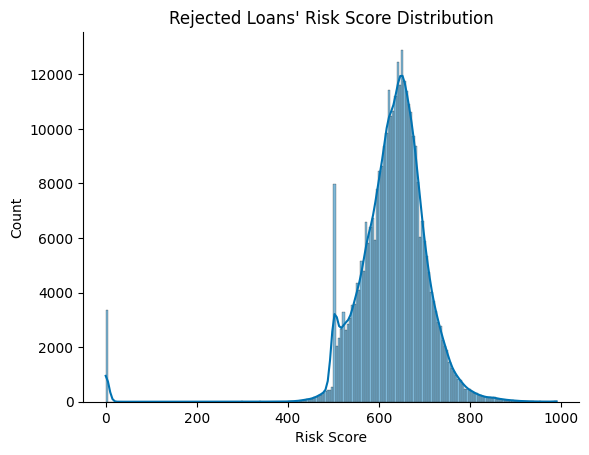

In [5]:
sns.histplot(df_rej_sample.select("Risk_Score"), kde=True, bins=200, legend=False)
plt.title("Rejected Loans' Risk Score Distribution")
plt.xlabel("Risk Score")
sns.despine()

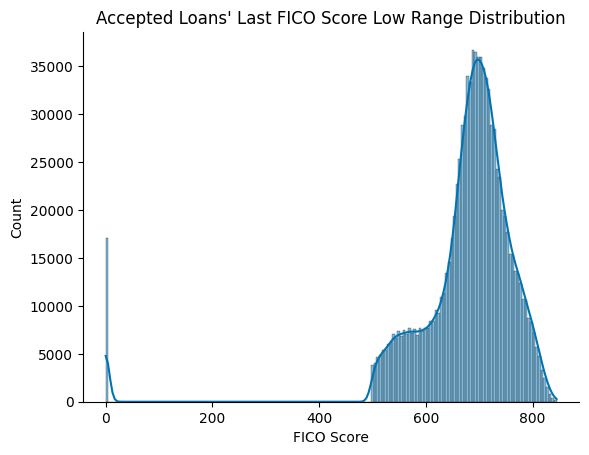

In [6]:
sns.histplot(
    df_acc_sample.select("last_fico_range_low"), kde=True, bins=170, legend=False
)
plt.title("Accepted Loans' Last FICO Score Low Range Distribution")
plt.xlabel("FICO Score")
sns.despine()

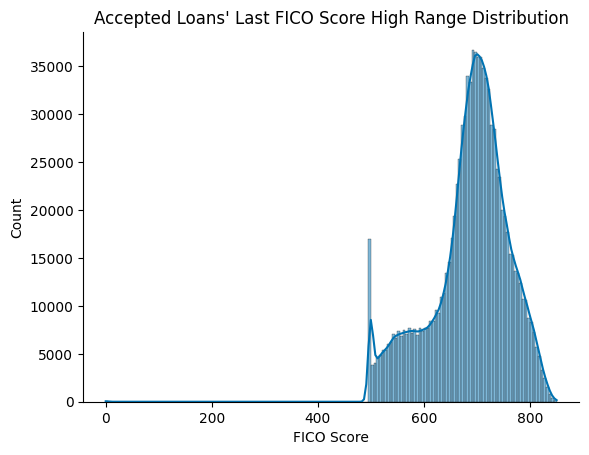

In [7]:
sns.histplot(
    df_acc_sample.select("last_fico_range_high"), kde=True, bins=170, legend=False
)
plt.title("Accepted Loans' Last FICO Score High Range Distribution")
plt.xlabel("FICO Score")
sns.despine()

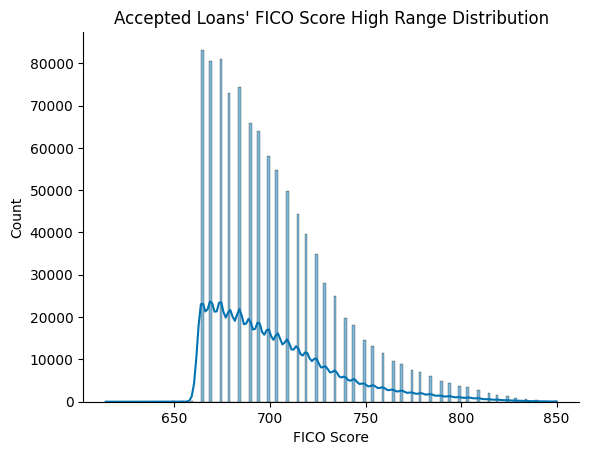

In [11]:
sns.histplot(df_acc_sample.select("fico_range_high"), kde=True, bins=170, legend=False)
plt.title("Accepted Loans' FICO Score High Range Distribution")
plt.xlabel("FICO Score")
sns.despine()

As we can see, "Risk Score" resembles FICO score, but it's in a different range and has a slightly different distribution. "Last FICO Score" is most likely a FICO score that's recorded after the loan being issued. "FICO score" most likely is the score recorded at the point in time when the loan is just being issued - we can see the cut off being at around 660.

Without knowing the exact transformation parameters I'm reluctant to try and include this in our combined dataset. What is more, more than 50% of "Risk Score" is missing a value.

#### Join

In [8]:
join_column_names = [
    "loan_amnt",
    "issue_d",
    "title",
    "dti",
    "zip_code",
    "addr_state",
    "emp_length",
    "policy_code",
]

# Prepare df_rej for join: drop Risk Score, parse issue date, cast dti.
df_rej_for_join = df_rej.drop("Risk_Score")
df_rej_for_join.columns = join_column_names
df_rej_for_join = functions.parse_to_datetime(df_rej_for_join, col="issue_d").drop(
    "issue_d"
)
df_rej_for_join = df_rej_for_join.with_columns(
    pl.col("dti").str.replace("%", "").alias("dti").cast(pl.Float64),
)

# prepare df_acc for join: select only the required columns, parse issue date.
df_acc_for_join = df_acc.select(join_column_names)
df_acc_for_join = functions.parse_to_datetime(
    df_acc_for_join, col="issue_d", fmt="%b-%Y"
).drop("issue_d")

It is not obvious what the policy_code feature is supposed to store. Let's aggregate and see.

In [9]:
df_rej_for_join.select("policy_code").group_by("policy_code").agg(pl.count())

policy_code,count
f64,u32
2.0,75531
null,874
0.0,24459165


In [10]:
df_acc_for_join.select("policy_code").group_by("policy_code").agg(pl.count())

policy_code,count
f64,u32
1.0,2069519


Policy code is always 1 for accepted loans, but may be something else for rejected. Therefore, we need to drop this feature before modelling.

In [11]:
df_rej_for_join = df_rej_for_join.drop("policy_code").with_columns(accepted=0)
df_acc_for_join = df_acc_for_join.drop("policy_code").with_columns(accepted=1)

df_comb = pl.concat([df_rej_for_join, df_acc_for_join])
df_comb_sample = df_comb.sample(1_000_000, seed=42)
df_comb_sample.sample(3)

loan_amnt,title,dti,zip_code,addr_state,emp_length,issue_d_parsed,accepted
f64,str,f64,str,str,str,datetime[μs],i32
3000.0,"""Debt consolida…",25.92,"""346xx""","""FL""","""< 1 year""",2018-10-31 00:00:00,0
1000.0,"""credit_card""",40.88,"""554xx""","""MN""","""< 1 year""",2017-01-03 00:00:00,0
10000.0,"""Debt consolida…",31.99,"""847xx""","""UT""","""< 1 year""",2018-04-07 00:00:00,0


We shall denote accepted loans by "1" and rejected - by "0".

Looking back at this cell, I could've sampled the data with stratification on "accepted" feature.

### EDA for the Combined Dataset

#### General Observations

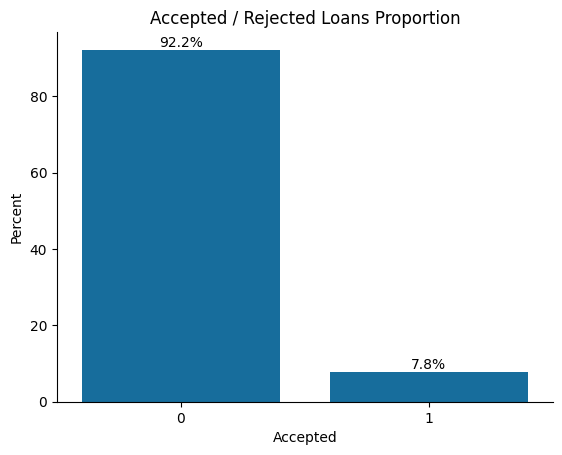

In [12]:
sns.countplot(x=df_comb_sample.select("accepted").to_series(), stat="percent")
functions.add_labels(fmt="%.1f%%")
plt.title("Accepted / Rejected Loans Proportion")
plt.xlabel("Accepted")
plt.ylabel("Percent")
sns.despine()

Since we didn't draw equal samples, the dataset is naturally dominated by rejected loans.

In [13]:
df_comb_sample.describe()

describe,loan_amnt,title,dti,zip_code,addr_state,emp_length,issue_d_parsed,accepted
str,f64,str,f64,str,str,str,str,f64
"""count""",1e6,"""1000000""",1e6,"""1000000""","""1000000""","""1000000""","""1000000""",1e6
"""null_count""",0.0,"""840""",55.0,"""10""","""0""","""36359""","""0""",0.0
"""mean""",13273.49469,null,135.946355,null,null,null,null,0.077583
"""std""",14520.973519,null,3267.736411,null,null,null,null,0.267514
"""min""",0.0,""" """,-1.0,"""000xx""","""AK""","""1 year""","""2007-05-29 00:…",0.0
"""25%""",5000.0,null,8.54,null,null,null,null,0.0
"""50%""",10000.0,null,19.63,null,null,null,null,0.0
"""75%""",20000.0,null,34.86,null,null,null,null,0.0
"""max""",300000.0,"""zero balance""",1.0728e6,"""999xx""","""WY""","""< 1 year""","""2018-10-31 00:…",1.0


In [14]:
functions.n_unique_in_each_col(df_comb_sample)

describe,loan_amnt,title,dti,zip_code,addr_state,emp_length,issue_d_parsed,accepted
str,i64,i64,i64,i64,i64,i64,i64,i64
"""n_unique""",1871,6791,27499,975,51,12,4008,2


Null counts are not very concerning. Seems like DTI has -1 in some rows which could denote missing info. Due to high cardinality title and zip code may not be very helpful features.

#### Loan Amount

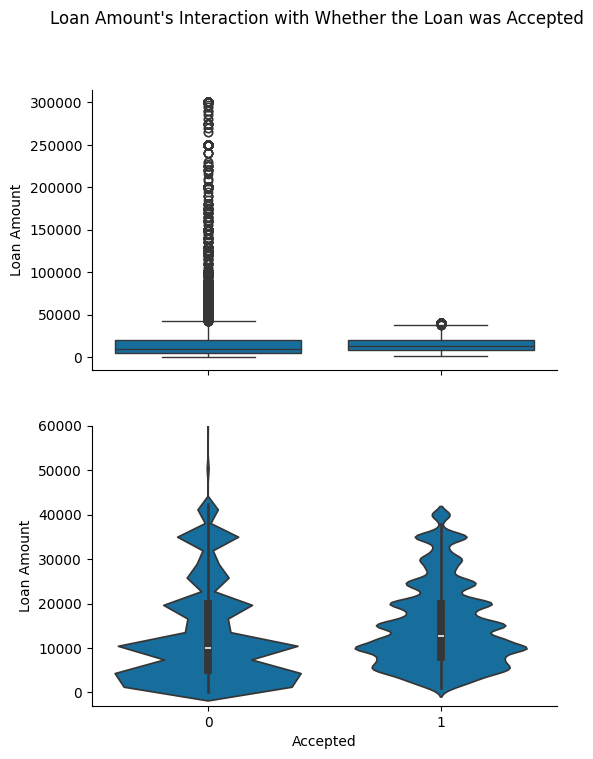

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_comb_sample.select(["loan_amnt", "accepted"]),
    y="loan_amnt",
    x="accepted",
    ax=ax[0],
)
sns.violinplot(
    data=df_comb_sample.select(["loan_amnt", "accepted"]),
    y="loan_amnt",
    x="accepted",
    ax=ax[1],
)
ax[0].set_ylabel("Loan Amount")
ax[1].set_ylabel("Loan Amount")
ax[1].set_xlabel("Accepted")
ax[1].set_ylim(-3_000, 60_000)
plt.suptitle("Loan Amount's Interaction with Whether the Loan was Accepted")
sns.despine()

In [16]:
functions.aggregations_by_group(df_comb_sample, by="accepted", agg_for="loan_amnt")

accepted,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
i32,f64,f64,f64,f64,f64,u32,u32,f64
0,0.0,5000.0,10000.0,20000.0,300000.0,922417,0,0.0
1,1000.0,8000.0,12800.0,20000.0,40000.0,77583,0,0.0


Accepted loans are capped from 1000 to 40k. They also seem to have a more condensed distribution and a higher median.

#### DTI

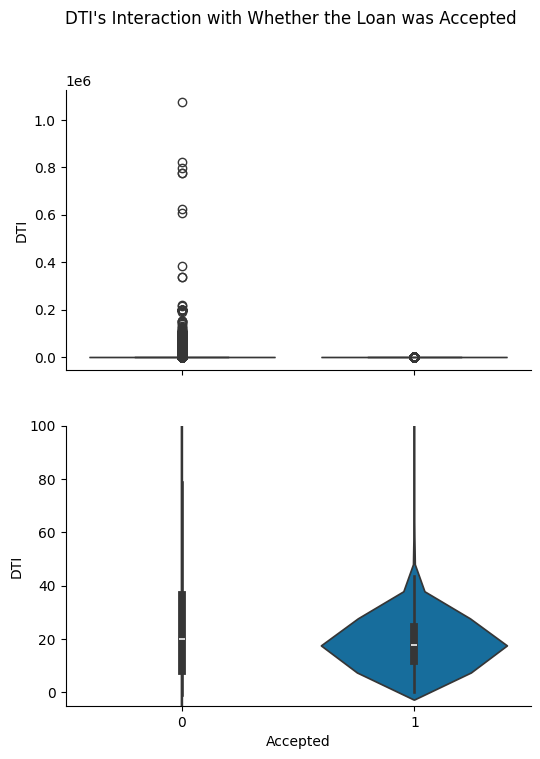

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
sns.boxplot(
    data=df_comb_sample.select(["dti", "accepted"]), y="dti", x="accepted", ax=ax[0]
)
sns.violinplot(
    data=df_comb_sample.select(["dti", "accepted"]), y="dti", x="accepted", ax=ax[1]
)
ax[0].set_ylabel("DTI")
ax[1].set_ylabel("DTI")
ax[1].set_xlabel("Accepted")
ax[1].set_ylim(-5, 100)
plt.suptitle("DTI's Interaction with Whether the Loan was Accepted")
sns.despine()

In [18]:
functions.aggregations_by_group(df_comb_sample, by="accepted", agg_for="dti")

accepted,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
i32,f64,f64,f64,f64,f64,u32,u32,f64
0,-1.0,8.03,19.92,36.4,1.0728e6,922417,0,0.0
1,0.0,11.82,17.85,24.49,999.0,77583,55,0.000709


In [19]:
test_replace_null = functions.replace_value_in_col(df_comb_sample, "dti", -1, None)
functions.aggregations_by_group(test_replace_null, by="accepted", agg_for="dti")

accepted,min,25%,median,75%,max,total_cnt,null_cnt,null_proportion
i32,f64,f64,f64,f64,f64,u32,u32,f64
0,0.0,9.74,21.04,37.43,1.0728e6,922417,41286,0.044758
1,0.0,11.82,17.85,24.49,999.0,77583,55,0.000709


Some of the loans are missing a value for DTI. In accepted loans these cells are empty, in rejected "-1" is imputed. For accepted loans DTI is capped at 999, which is a suspicious number. Again, accepted loans' DTI distribution is much more condensed.

A good Insight from this data would be that a little debt gives more credibility, but a too big of a debt deters everyone.

#### Employment Length

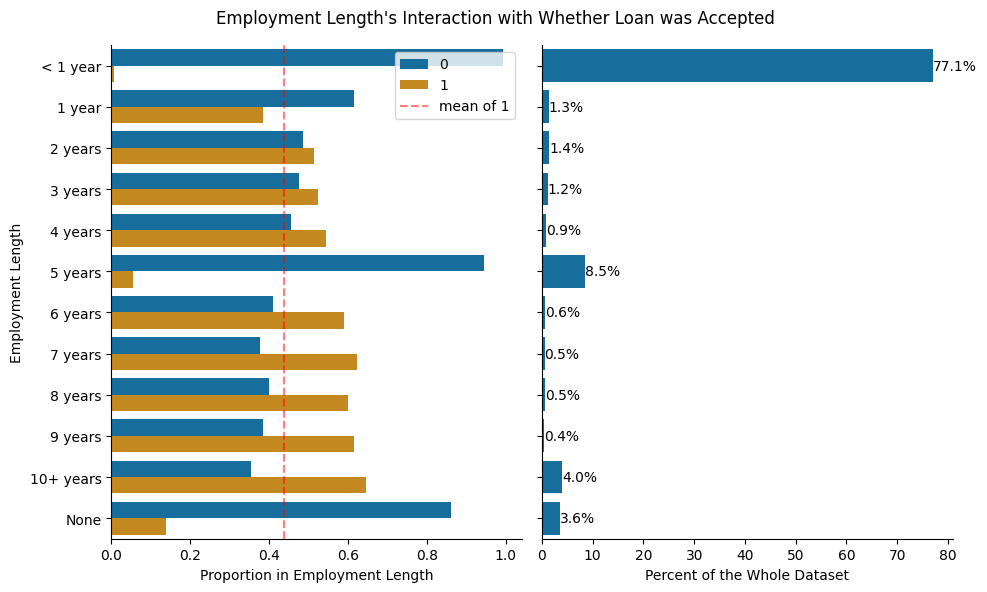

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_comb_sample,
    x="emp_length",
    hue="accepted",
    ax=ax,
    order=constants.emp_length_order_eda,
    for_step2=True,
)
ax[0].set_xlabel("Proportion in Employment Length")
ax[0].set_ylabel("Employment Length")
ax[1].set_xlabel("Percent of the Whole Dataset")
plt.suptitle("Employment Length's Interaction with Whether Loan was Accepted")
fig.tight_layout()

The majority of applicants fall into the "< 1 year" group and the majority of those loans get rejected. Generally, it seems that a longer employment length gives a better chance of the loan being accepted. However, the 5 years group looks odd, there's quite a lot of applicants in that category.

#### Date

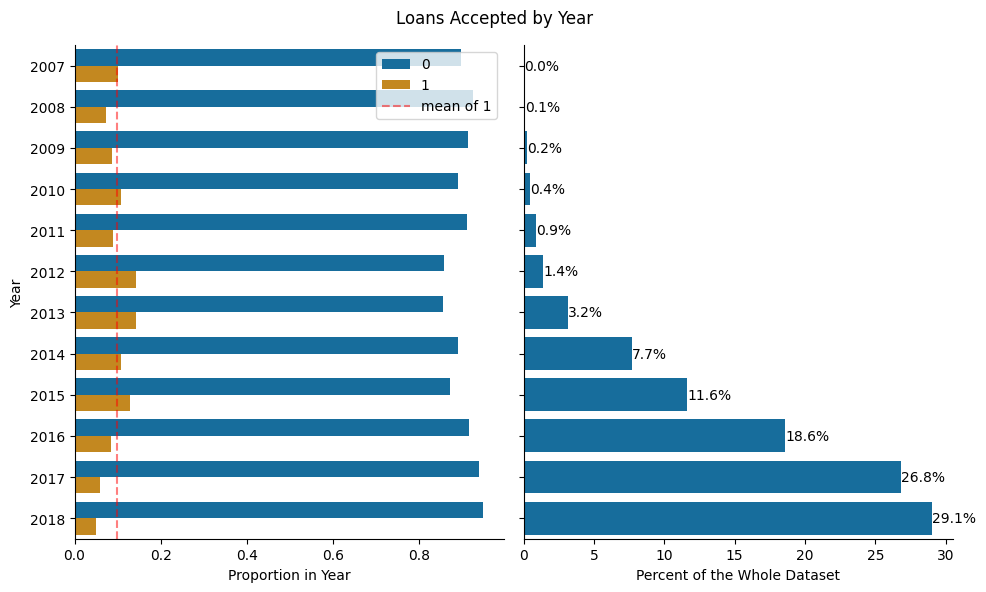

In [21]:
df_comb_sample_dt = functions.add_year_month(df_comb_sample, "issue_d_parsed")

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_comb_sample_dt, x="issue_d_parsed_year", hue="accepted", ax=ax, for_step2=True
)
ax[0].set_xlabel("Proportion in Year")
ax[0].set_ylabel("Year")
ax[1].set_xlabel("Percent of the Whole Dataset")
plt.suptitle("Loans Accepted by Year")
fig.tight_layout()

Looking at the figure it seems that there is some sort of a yearly pattern, as in 2017-2018 the proportion of accepted loans was 2-3 times lower than during 2012-2015.

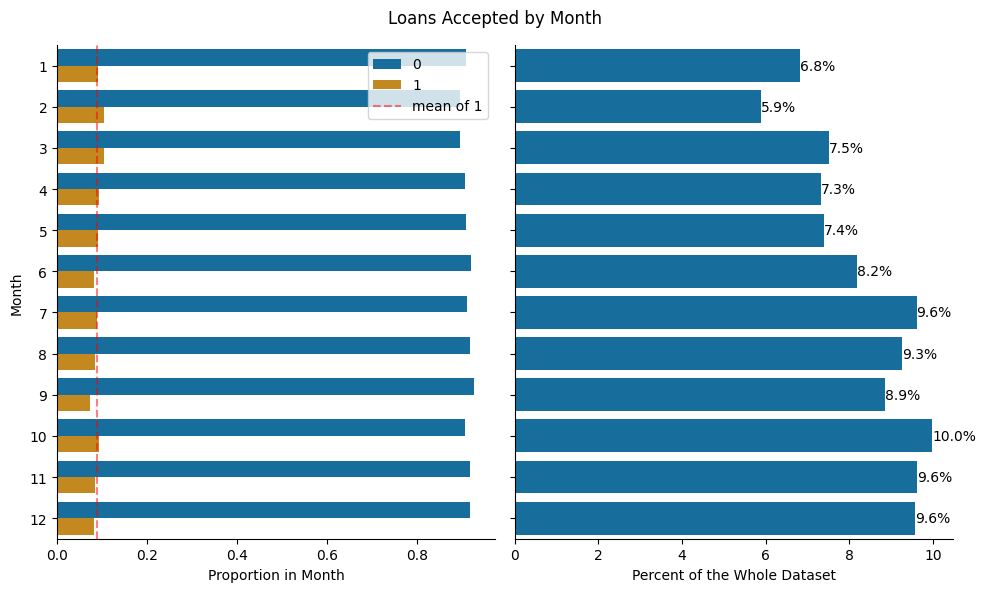

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(
    df_comb_sample_dt.filter(pl.col("issue_d_parsed_year") < 2018),
    x="issue_d_parsed_month",
    hue="accepted",
    ax=ax,
    for_step2=True,
)
ax[0].set_xlabel("Proportion in Month")
ax[0].set_ylabel("Month")
ax[1].set_xlabel("Percent of the Whole Dataset")
plt.suptitle("Loans Accepted by Month")
fig.tight_layout()

There doesn't seem to be any obvious pattern when analysing the proportions by month.

### Title

In [59]:
functions.clean_text_in_cols(df_comb_sample, ["title"]).select(
    "title"
).to_series().value_counts(sort=True).to_pandas().head(10)

,title,counts
0,debtconsolidation,679334
1,other,237747
2,creditcardrefinancing,131847
3,creditcard,72642
4,homeimprovement,69223
5,majorpurchase,50196
6,carfinancing,37575
7,car,28075
8,homebuying,23480
9,moving,20575


The title column seems to contain free writing, but we can aggregate it a bit with some simple transformations. Initially I tried fitting a model without these transformations and title was the most important feature by far.

## Model

Let's create the first model. We'll use approximately 1M of data for training and 0.5M for validation.

In [ ]:
df_comb_sample = df_comb.sample(1_500_000, seed=42)
df_comb_sample = functions.clean_text_in_cols(df_comb_sample, ["title"])
df_comb_sample_train, df_comb_sample_valid = train_test_split(
    df_comb_sample, test_size=0.33
)

df_comb_sample_train = (
    df_comb_sample_train.pipe(functions.replace_value_in_col, col="dti")
    .pipe(functions.add_year_month, date_col="issue_d_parsed")
    .drop_nulls()
)
X1_train = df_comb_sample_train.drop("accepted")
y1_train = df_comb_sample_train.select("accepted")

df_comb_sample_valid = df_comb_sample_valid.pipe(
    functions.replace_value_in_col, col="dti"
).pipe(functions.add_year_month, date_col="issue_d_parsed")
X1_valid = df_comb_sample_valid.drop("accepted")
y1_valid = df_comb_sample_valid.select("accepted")

Let's create a preprocessor and fit our initial model.

In [48]:
continuous_features = ["loan_amnt", "dti"]
continuous_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

target_features = ["zip_code", "addr_state", "title"]
target_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder(target_type="binary", shuffle=False)),
    ]
)

date_features = ["issue_d_parsed_year", "issue_d_parsed_month"]
date_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

employment_features = ["emp_length"]
employment_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent", missing_values=None)),
        ("encoder", OrdinalEncoder(categories=[constants.emp_length_order])),
    ]
)

drop_features = ["issue_d_parsed"]

preprocessor = ColumnTransformer(
    [
        ("continuous_pipe", continuous_pipe, continuous_features),
        ("target_pipe", target_pipe, target_features),
        ("date_pipe", date_pipe, date_features),
        ("employment_pipe", employment_pipe, employment_features),
        ("drop", "drop", drop_features),
    ],
    verbose_feature_names_out=False,
)

X1_train_tf = preprocessor.fit_transform(X1_train.to_pandas(), y1_train.to_series())
X1_train_tf_named = pd.DataFrame(
    X1_train_tf, columns=preprocessor.get_feature_names_out()
)
model = DecisionTreeClassifier(max_depth=20, random_state=42).fit(
    X1_train_tf_named, y1_train.to_series()
)

Let's see the feature importances based on shap.

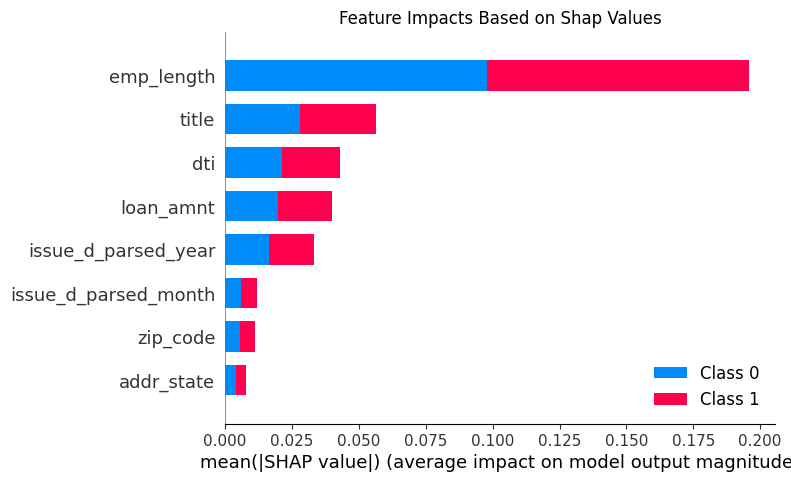

In [49]:
X1_valid_tf = preprocessor.transform(X1_valid.to_pandas())
X1_valid_tf_named = pd.DataFrame(
    X1_valid_tf, columns=preprocessor.get_feature_names_out()
)
X1_valid_tf_named_sample = X1_valid_tf_named.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X1_valid_tf_named_sample)

shap.summary_plot(shap_vals, X1_valid_tf_named_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()

Employment length plays the biggest role in our model, followed by title (surprise), DTI and loan amount. Year is among the more impactful features, but we need not to forget that using it in a finished model could not be a good idea. other variables have less impact.

And here's the confusion matrix:

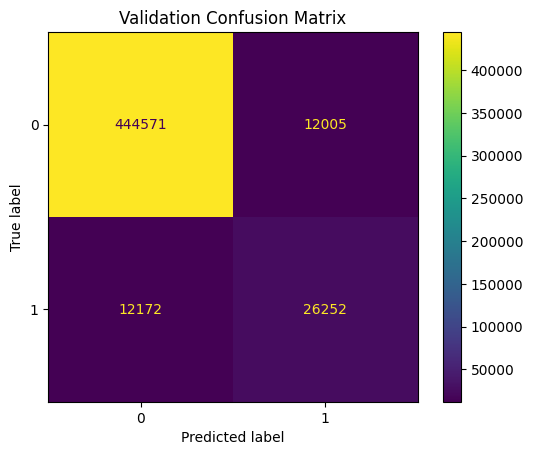

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    456576
           1       0.69      0.68      0.68     38424

    accuracy                           0.95    495000
   macro avg       0.83      0.83      0.83    495000
weighted avg       0.95      0.95      0.95    495000



In [50]:
y_preds = model.predict(X1_valid_tf_named)
conf_mx = confusion_matrix(y1_valid.to_series(), y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=model.classes_)
disp.plot()
plt.title("Validation Confusion Matrix")
plt.show()
print(classification_report(y1_valid.to_series(), y_preds, zero_division=0))

Not too bad for an initial model. Let's try tuning.

In [51]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    X_train, X_eval, y_train, y_eval = train_test_split(
        X1_train, y1_train, test_size=0.2, random_state=42
    )
    weight = trial.suggest_float("weight", 1e-2, 1e2)
    params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 100),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 1000),
        class_weight={1: weight},
        random_state=42,
    )
    model = DecisionTreeClassifier(**params)
    preprocessor = ColumnTransformer(
        [
            ("continuous_pipe", continuous_pipe, continuous_features),
            ("address_pipe", target_pipe, target_features),
            ("date_pipe", date_pipe, date_features),
            ("employment_pipe", employment_pipe, employment_features),
            ("drop", "drop", drop_features),
        ],
        verbose_feature_names_out=False,
    )
    X_train_tf = preprocessor.fit_transform(X_train.to_pandas(), y_train.to_series())
    X_eval_tf = preprocessor.transform(X_eval.to_pandas())
    model.fit(X_train_tf, y_train.to_series())
    y_pred = model.predict(X_eval_tf)
    f1 = f1_score(y_eval, y_pred, average="weighted")
    return f1


sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=2)
dt_params = study.best_params
dt_params

{'weight': 1.5742725963357997, 'max_depth': 53, 'min_samples_split': 293}

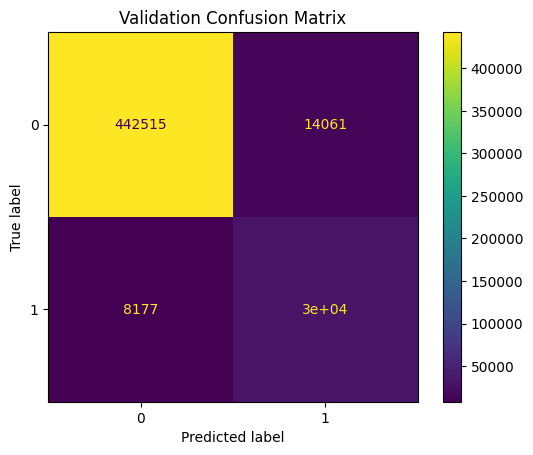

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    456576
           1       0.68      0.79      0.73     38424

    accuracy                           0.96    495000
   macro avg       0.83      0.88      0.85    495000
weighted avg       0.96      0.96      0.96    495000



In [52]:
# fit
X1_train_tf = preprocessor.fit_transform(X1_train.to_pandas(), y1_train.to_series())
X1_train_tf_named = pd.DataFrame(
    X1_train_tf, columns=preprocessor.get_feature_names_out()
)
model = DecisionTreeClassifier(
    max_depth=dt_params["max_depth"],
    min_samples_split=dt_params["min_samples_split"],
    class_weight={1: dt_params["weight"]},
    random_state=42,
).fit(X1_train_tf_named, y1_train.to_series())

# predict
X1_valid_tf = preprocessor.transform(X1_valid.to_pandas())
X1_valid_tf_named = pd.DataFrame(
    X1_valid_tf, columns=preprocessor.get_feature_names_out()
)
y_preds = model.predict(X1_valid_tf_named)

# confusion matrix
conf_mx = confusion_matrix(y1_valid.to_series(), y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=model.classes_)
disp.plot()
plt.title("Validation Confusion Matrix")
plt.show()
print(classification_report(y1_valid.to_series(), y_preds, zero_division=0))

Tuning quite successful - recall for accepted loans has improved significantly without altering the other scores too much. However, this final model does not achieve the macro f1 score of 0.9.

## This Notebook's Output

If we'd want to deploy a model making the decision to accept or reject a loan, there is certainly enough data to do that with some accuracy. Moreover, we could fit the model to all data without sampling, which should increase the model's accuracy. This path can be explored if such a model is needed. Even a simple decision tree trained on a small sample of the data performs quite well. 

However, the rejected loans dataset includes very little information on the credit risk of the applicants, only the "Risk Score" which has a lot of null values and unknown transformations. Therefore, I would prefer to gather better data or at least find out how to work with the "Risk Score" before exploring this classification topic further.